# Building and exporting the lattice

The package used for building the lattice, and it's plotting can be found on the website:
http://docs.pybinding.site/en/stable/, with the installation guide and many building examples
provided.

In [ ]:
# Include directories

In [8]:
import pybinding as pb
import numpy as np
import matplotlib.pyplot as plt
import h5py as hp

from math import sqrt

In [ ]:
# a = 0.24595  # [nm] unit cell length
# a_cc = 0.142  # [nm] carbon-carbon distance
# t = -2.8  # [eV] nearest neighbour hopping

In [10]:
from pybinding.repository.graphene import a_cc, a, t, t_nn

pb.pltutils.use_style()

In [11]:
# Define function for the lattice, in this case Monolayer graphene

In [12]:
def monolayer_graphene(nearest_neighbors=1, onsite=(0, 0), **kwargs):
    """Return the lattice specification for monolayer graphene"""

    # create a lattice with 2 primitive vectors
    lat = pb.Lattice(
        a1=[a, 0],
        a2=[a / 2, a / 2 * sqrt(3)]
    )

    # num of orbitals at each site is equal to the number of rows of the onsite object
    # the number of orbitals can be different, and the only limitation is that the hopping element between the two sites
    #  needs to be of the size num_orbitals_a x num_orbitals_b.
    num_orbitals_a = np.asarray(onsite[0]).shape[0]
    num_orbitals_b = np.asarray(onsite[0]).shape[0]

    # register name for hoppings
    lat.register_hopping_energies({
        't': kwargs.get('t', t * np.eye(num_orbitals_a)),
        't_nn': kwargs.get('t_nn', t_nn * np.eye(num_orbitals_b)),
        't_nnn': kwargs.get('t_nnn', 0.05 * np.eye(num_orbitals_a)),
    })

    coord_A = [0, -a_cc / 2]
    coord_B = [0, a_cc / 2]

    lat.add_sublattices(
        # name, position, and onsite potential
        ('A', coord_A, onsite[0]),
        ('B', coord_B, onsite[1])
    )

    lat.add_hoppings(
        # inside the main cell
        ([0, 0], 'A', 'B', 't'),
        # between neighboring cells
        ([1, -1], 'A', 'B', 't'),
        ([0, -1], 'A', 'B', 't')
    )

    if nearest_neighbors >= 2:
        lat.add_hoppings(
            ([0, -1], 'A', 'A', 't_nn'),
            ([0, -1], 'B', 'B', 't_nn'),
            ([1, -1], 'A', 'A', 't_nn'),
            ([1, -1], 'B', 'B', 't_nn'),
            ([1, 0], 'A', 'A', 't_nn'),
            ([1, 0], 'B', 'B', 't_nn'),
        )

    if nearest_neighbors >= 3:
        lat.add_hoppings(
            [(1, -2), 'A', 'B', 't_nnn'],
            [(1, 0), 'A', 'B', 't_nnn'],
            [(-1, 0), 'A', 'B', 't_nnn'],
        )

    if nearest_neighbors >= 4:
        raise RuntimeError("No more")

    lat.min_neighbors = 2
    return lat

In [13]:
# define Config class which carries info about:
# - the number of decomposition parts [nx, ny],
# - lenghts of structure [lx, ly]
# - boundary conditions, setting True as periodic boundary conditions, and False elsewise,
# - info if the exported hopping and onsite data should be complex,
# - info of the precision of the exported hopping and onsite data, 0 - float, 1 - double, and 2 - long double. 

In [14]:
class Config:
    def __init__(self, divisions=(1, 1), length=None, boundaries=(False, False), is_complex=False, precision=1):
        self._is_complex = int(is_complex)
        self._precision = precision
        self._divisions = divisions
        self._boundaries = np.asarray(boundaries).astype(int)
        self._length = length
        self.set_type()

    def set_type(self, ):
        if self._is_complex == 0:
            if self._precision == 0:
                self._htype = np.float32
            elif self._precision == 1:
                self._htype = np.float64
            elif self._precision == 2:
                self._htype = np.float128
            else:
                raise SystemExit("Precision should be 0, 1 or 2")
        else:
            if self._precision == 0:
                self._htype = np.complex64
            elif self._precision == 1:
                self._htype = np.complex128
            elif self._precision == 2:
                self._htype = np.complex256

    @property
    def comp(self):  # -> is_complex:
        """Returns 0 if hamiltonian is real and 1 elsewise."""
        return self._is_complex

    @property
    def prec(self):  # -> precision:
        """Returns 0, 1, 2 if precision if float, double, and long double respectively."""
        return self._precision

    @property
    def div(self):  # -> divisions:
        """Returns the number of decomposed elements of matrix in x and y direction. Product of the two gives the total
        number of threads spawn."""
        return self._divisions

    @property
    def bound(self):  # -> boundaries:
        """Returns the boundary conditions in each direction, 0 - no boundary condtions, 1 - peridoc bc. """
        return self._boundaries

    @property
    def leng(self):  # -> length:
        """Return the number of unit cell repetitions in each direction. """
        return self._length

    @property
    def type(self):  # -> type:
        """Return the type of the Hamiltonian complex or real, and float, double or long double. """
        return self._htype

In [15]:
# define function that exports the lattice and configuration data

In [16]:
def export_lattice(lattice, config, filename):
    # get the lattice vectors and set the size of space (1D, 2D or 3D) as the total number of vectors.
    vectors = lattice.vectors
    space_size = len(vectors)

    # get all the onsite values (as numbers or matrices) to the onsite array.
    onsite = []
    # get all positions to the position array.
    position = []
    # get number of orbitals at each atom.
    num_orbitals = []

    for name, sub in lattice.sublattices.items():
        num_orbitals.append(np.asarray(sub.energy).shape[0])
        onsite.append(sub.energy)
        position.append(sub.position[0:space_size])
    onsite = np.array(onsite)
    position = np.array(position)

    hoppings_id = []
    hoppings = []
    # hopping_id matrix is made of the following data:
    # - each row is representing one hopping element,
    # - first space_size elements (1, 2, or 3) represent the relative lattice index with respect
    #   to the [0, 0, 0] lattice,
    # - next 2 numbers show the relative index of the atom in the lattice [0, 0, 0] from which the hopping comes
    #   and the relative index of the atom in the lattice given at the beginning of the row where the hopping goes.
    # - final two numbers are the number of rows and cols of hopping matrix which represent the number of orbitals of
    #   atom "from" and atom "to" between which the hopping happens.

    # hopping matrix with each row represents one hopping element (in case of the matrix the hopping is flatened
    # to fit the row) with properties given in the same row of matrix hopping_id.
    for name, hop in lattice.hoppings.items():
        hopping_energy = hop.energy
        for term in hop.terms:
            hoppings_id.append(np.hstack((term.relative_index[0:space_size].flatten(),
                                          getattr(term, "from"), term.to, hopping_energy.shape)))
            hoppings.append(hopping_energy.flatten())

    hoppings = np.array(hoppings)
    hoppings_id = np.array(hoppings_id)

    f = hp.File(filename, "w")
    # hamiltonian is complex 1 or real 0
    complx = int(config.comp)
    f.create_dataset("IsComplex", data=complx)
    # precision of hamiltonian float, double, long double
    f.create_dataset("Precision", data=config.prec)
    # number of repetitions in each of the directions
    f.create_dataset("Length", data=config.leng, dtype="u4")
    # periodic boundary conditions, 0 - no, 1 - yes.
    bound = config.bound
    f.create_dataset("Boundaries", data=bound, dtype="u4")
    # number of divisions of the in each direction of hamiltonian. nx x ny = num_threads
    f.create_dataset("Divisions", data=config.div, dtype="u4")
    # space dimension of the lattice 1D, 2D, 3D
    f.create_dataset("Dim", data=space_size, dtype="u4")
    # lattice vectors. Size is same as DIM
    f.create_dataset("LattVector", data=vectors, dtype=np.float64)
    # position for each atom
    f.create_dataset("AtomPositions", data=position, dtype=np.float64)
    # total number of atom
    f.create_dataset("NumAtoms", data=position.shape[0], dtype="u4")
    # Hamiltonian group
    grp = f.create_group("Hamiltonian")
    # Hamiltonian group
    grp.create_dataset("HoppingsID", data=hoppings_id)
    # number of orbitals at each atom
    grp.create_dataset("NumOrbitals", data=num_orbitals)
    if (complx):
        # hoppings
        grp.create_dataset("Hoppings", data=hoppings.astype(config.type))
        # onsite
        grp.create_dataset("Onsite", data=onsite.astype(config.type))
    else:
        # hoppings
        grp.create_dataset("Hoppings", data=hoppings.real.astype(config.type))
        # onsite potential at each atom
        grp.create_dataset("Onsite", data=onsite.real.astype(config.type))

    f.close()

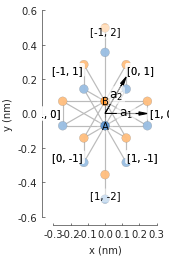

In [17]:
# define lattice of monolayer graphene by setting the number of nearest neighbors and onsite energies at atoms.
# onsite energies can be a number, array, or matrix, where for the last case off-diagonal terms represent orbital
# hoppings at the same lattice site.
lattice = monolayer_graphene(nearest_neighbors=3, onsite=([[1, 1], [1, 2]], [[1, 1], [1, 2]]))

# plotting the lattice
lattice.plot()
plt.show()

# number of decomposition parts in each direction of matrix.
nx = ny = 1
# number of unit cells in each direction.
lx = ly = 1
# make config object which caries info about
# - the number of decomposition parts [nx, ny],
# - lenghts of structure [lx, ly]
# - boundary conditions, setting True as periodic boundary conditions, and False elsewise,
# - info if the exported hopping and onsite data should be complex,
# - info of the precision of the exported hopping and onsite data, 0 - float, 1 - double, and 2 - long double.
config = Config(divisions=[nx, ny], length=[lx, ly], boundaries=[True, True], is_complex=False, precision=1)

# export the latice from the lattice object, config file, and the name of the file
export_lattice(lattice, config, "test.h5")